In [1]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [3]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [4]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [12]:
# 子类API
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# 复合函数：f(x) = h(g(x))

concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [input], outputs = [output])

class WideDeepModel(keras.models.Model):
    def __init__(self):
        super().__init__()
        '''定义模型的层次'''
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
    
    def call(self, input):
        '''完成模型的正向计算'''
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output

# model = WideDeepModel()
model = keras.models.Sequential([
    WideDeepModel(),
])
model.build(input_shape=(None, 8))

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)
]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide_deep_model_1 (WideDeepM (None, 1)                 1239      
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x_train_scaled, y_train,
                   validation_data=(x_valid_scaled, y_valid),
                   epochs=100,
                   callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 0s 1ms/step - loss: 1.3598 - val_loss: 0.5979
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4491 - val_loss: 0.4338
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3983 - val_loss: 0.4033
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3836 - val_loss: 0.3977
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3762 - val_loss: 0.3875
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3694 - val_loss: 0.3752
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3644 - val_loss: 0.3697
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3575 - val_loss: 0.3650
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3485 - val_loss: 0.3561
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3417 - val_lo

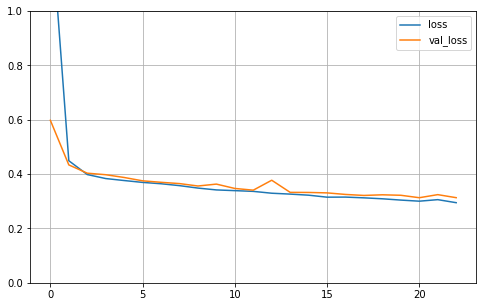

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [15]:
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 748us/step - loss: 0.3193


0.31926265358924866